In [173]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from validphys.api import API

from ht_plot_utlis import plot_covmat_heatmap
from ht_utlis import TCM, HTset

In [2]:
fitname = "241004-ach-02-test-ht"
thcovmat_dict = API.fit(fit=fitname).as_input()["theorycovmatconfig"]
ht_parameters = thcovmat_dict['ht_parameters']
fitpath = API.fit(fit=fitname).path

Construct the index used to label the parameters used to parameterise the higher twist

In [3]:
ht_names = []
ht_nodes = []
x_nodes = {}
beta_tilde = []
for ht in ht_parameters:
  beta_tilde.append(ht['list'])
  x_nodes[ht['ht']] = ht['nodes']
  for idx_node in range(len(ht['list'])):
    ht_names.append(ht['ht'])
    ht_nodes.append(ht['ht'] + f"({idx_node})")
    
beta_tilde = np.concatenate(beta_tilde)

# Compute beta_tilde according to the 5pt prescription
tmp_mat = np.zeros(shape=(len(beta_tilde), len(beta_tilde)))
np.fill_diagonal(tmp_mat, beta_tilde)
  

ht_index_tuple = list(zip(ht_names, ht_nodes))
ht_index = pd.MultiIndex.from_tuples(ht_index_tuple, names=["HT", "nodes"])
beta_tilde = pd.DataFrame(tmp_mat, index=ht_index, columns=ht_index)

In [4]:
save_dir = f"./Results/{fitname}"
target_dir = Path(save_dir)
pickle_path = Path(save_dir + "/posteriors.pkl")
if not target_dir.is_dir():
  target_dir.mkdir(parents=True, exist_ok=True)

In [5]:
common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fitname,
    fits=[fitname],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
    theory={"from_": "fit"},
    theoryid={"from_": "theory"},
)

# Calculate theory predictions of the input PDF
S_dict = dict(
    theorycovmatconfig={"from_": "fit"},
    pdf={"from_": "theorycovmatconfig"},
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
)

In [6]:
# Calculate theory predictions of the fit with ht covmat - this will be compared to data
preds = API.group_result_table_no_table(pdf={"from_": "fit"}, **common_dict)

LHAPDF 6.5.4 loading all 501 PDFs in set 241004-ach-02-test-ht
241004-ach-02-test-ht, version 1; 501 PDF members


In [7]:
preds_onlyreplicas = preds.iloc[:, 2:].to_numpy()
mean_prediction = np.mean(preds_onlyreplicas, axis=1)

In [8]:
# Experimental covariance matrix
C = API.groups_covmat_no_table(**common_dict)

### Load theory covmat

In [9]:
try:
    S = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_user_covmat.csv",
        sep="\t",
        encoding="utf-8",
        index_col=2,
        header=3,
        skip_blank_lines=False,
    )
except FileNotFoundError:
    S = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_theory_covmat_custom.csv",
        index_col=[0, 1, 2],
        header=[0, 1, 2],
        sep="\t|,",
        engine="python",
    ).fillna(0)
    storedcovmat_index = pd.MultiIndex.from_tuples(
        [(aa, bb, np.int64(cc)) for aa, bb, cc in S.index],
        names=["group", "dataset", "id"],
    )
    S = pd.DataFrame(
        S.values, index=storedcovmat_index, columns=storedcovmat_index
    )
    S = S.reindex(C.index).T.reindex(C.index)

### Load beta

In [10]:
beta = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_table_ht_deltas.csv",
        index_col=[0, 1, 2],
        sep="\t|,",
        engine="python",    
).fillna(0)

Test if loaded $\beta$'s reconstruct the stored theory covmat

In [11]:
S_test = np.zeros((beta.shape[0], beta.shape[0]))
for shift in beta.columns:
    S_test += np.outer(beta[shift].to_numpy(), beta[shift].to_numpy())

S_test = pd.DataFrame(S_test, index=beta.index, columns=beta.index)
S_test = S_test.reindex(C.index).T.reindex(C.index)

In [12]:
np.allclose(S.to_numpy(), S_test.to_numpy())

True

Sum theory and experimental covmat and invert

In [13]:
invcov = np.linalg.inv(C + S)

Define the DataFrame containing the central values of the prior for each parameter.

In [14]:
central_ht_coeffs = pd.DataFrame(np.zeros(ht_index.shape), index=ht_index, columns=['central'])

### Collect central data

In [15]:
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_central = np.mean(
    [i.pseudodata.reindex(preds.index.to_list()).to_numpy().flatten() for i in pseudodata],
    axis=0,
)

In [16]:
tcm = TCM(mean_prediction=mean_prediction, preds_onlyreplicas=preds_onlyreplicas, index=ht_index, invcov=invcov, dat_central=dat_central, prior_central_value=central_ht_coeffs)

In [17]:
S_tilde = TCM.construct_S_tilde(beta_tilde)
S_hat = TCM.construct_S_hat(beta_tilde, beta)
X = TCM.construct_X(preds_onlyreplicas, mean_prediction)

In [60]:
P_tilde = TCM.calculate_correaltions(S_hat, invcov, X, S_tilde)
posteriors = TCM.calculate_posterior(invcov, S_hat, mean_prediction, dat_central, central_ht_coeffs['central'])

# Store in pkl
pd.to_pickle(posteriors, save_dir + '/posteriors.pkl')
pd.to_pickle(P_tilde, save_dir + '/P_tilde.pkl')

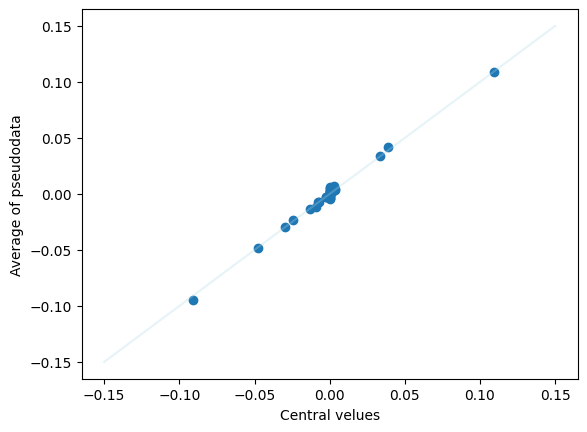

In [61]:
seed = 12413531412
HT = HTset(posteriors, P_tilde, x_nodes, True)
HT.generate_set(5000, seed, True)

In [166]:
from ht_utlis import H2_minus_abmp, H2_plus_abmp, Ht_minus_abmp, Ht_plus_abmp, H_2_abmp, H_L, H_T_abmp

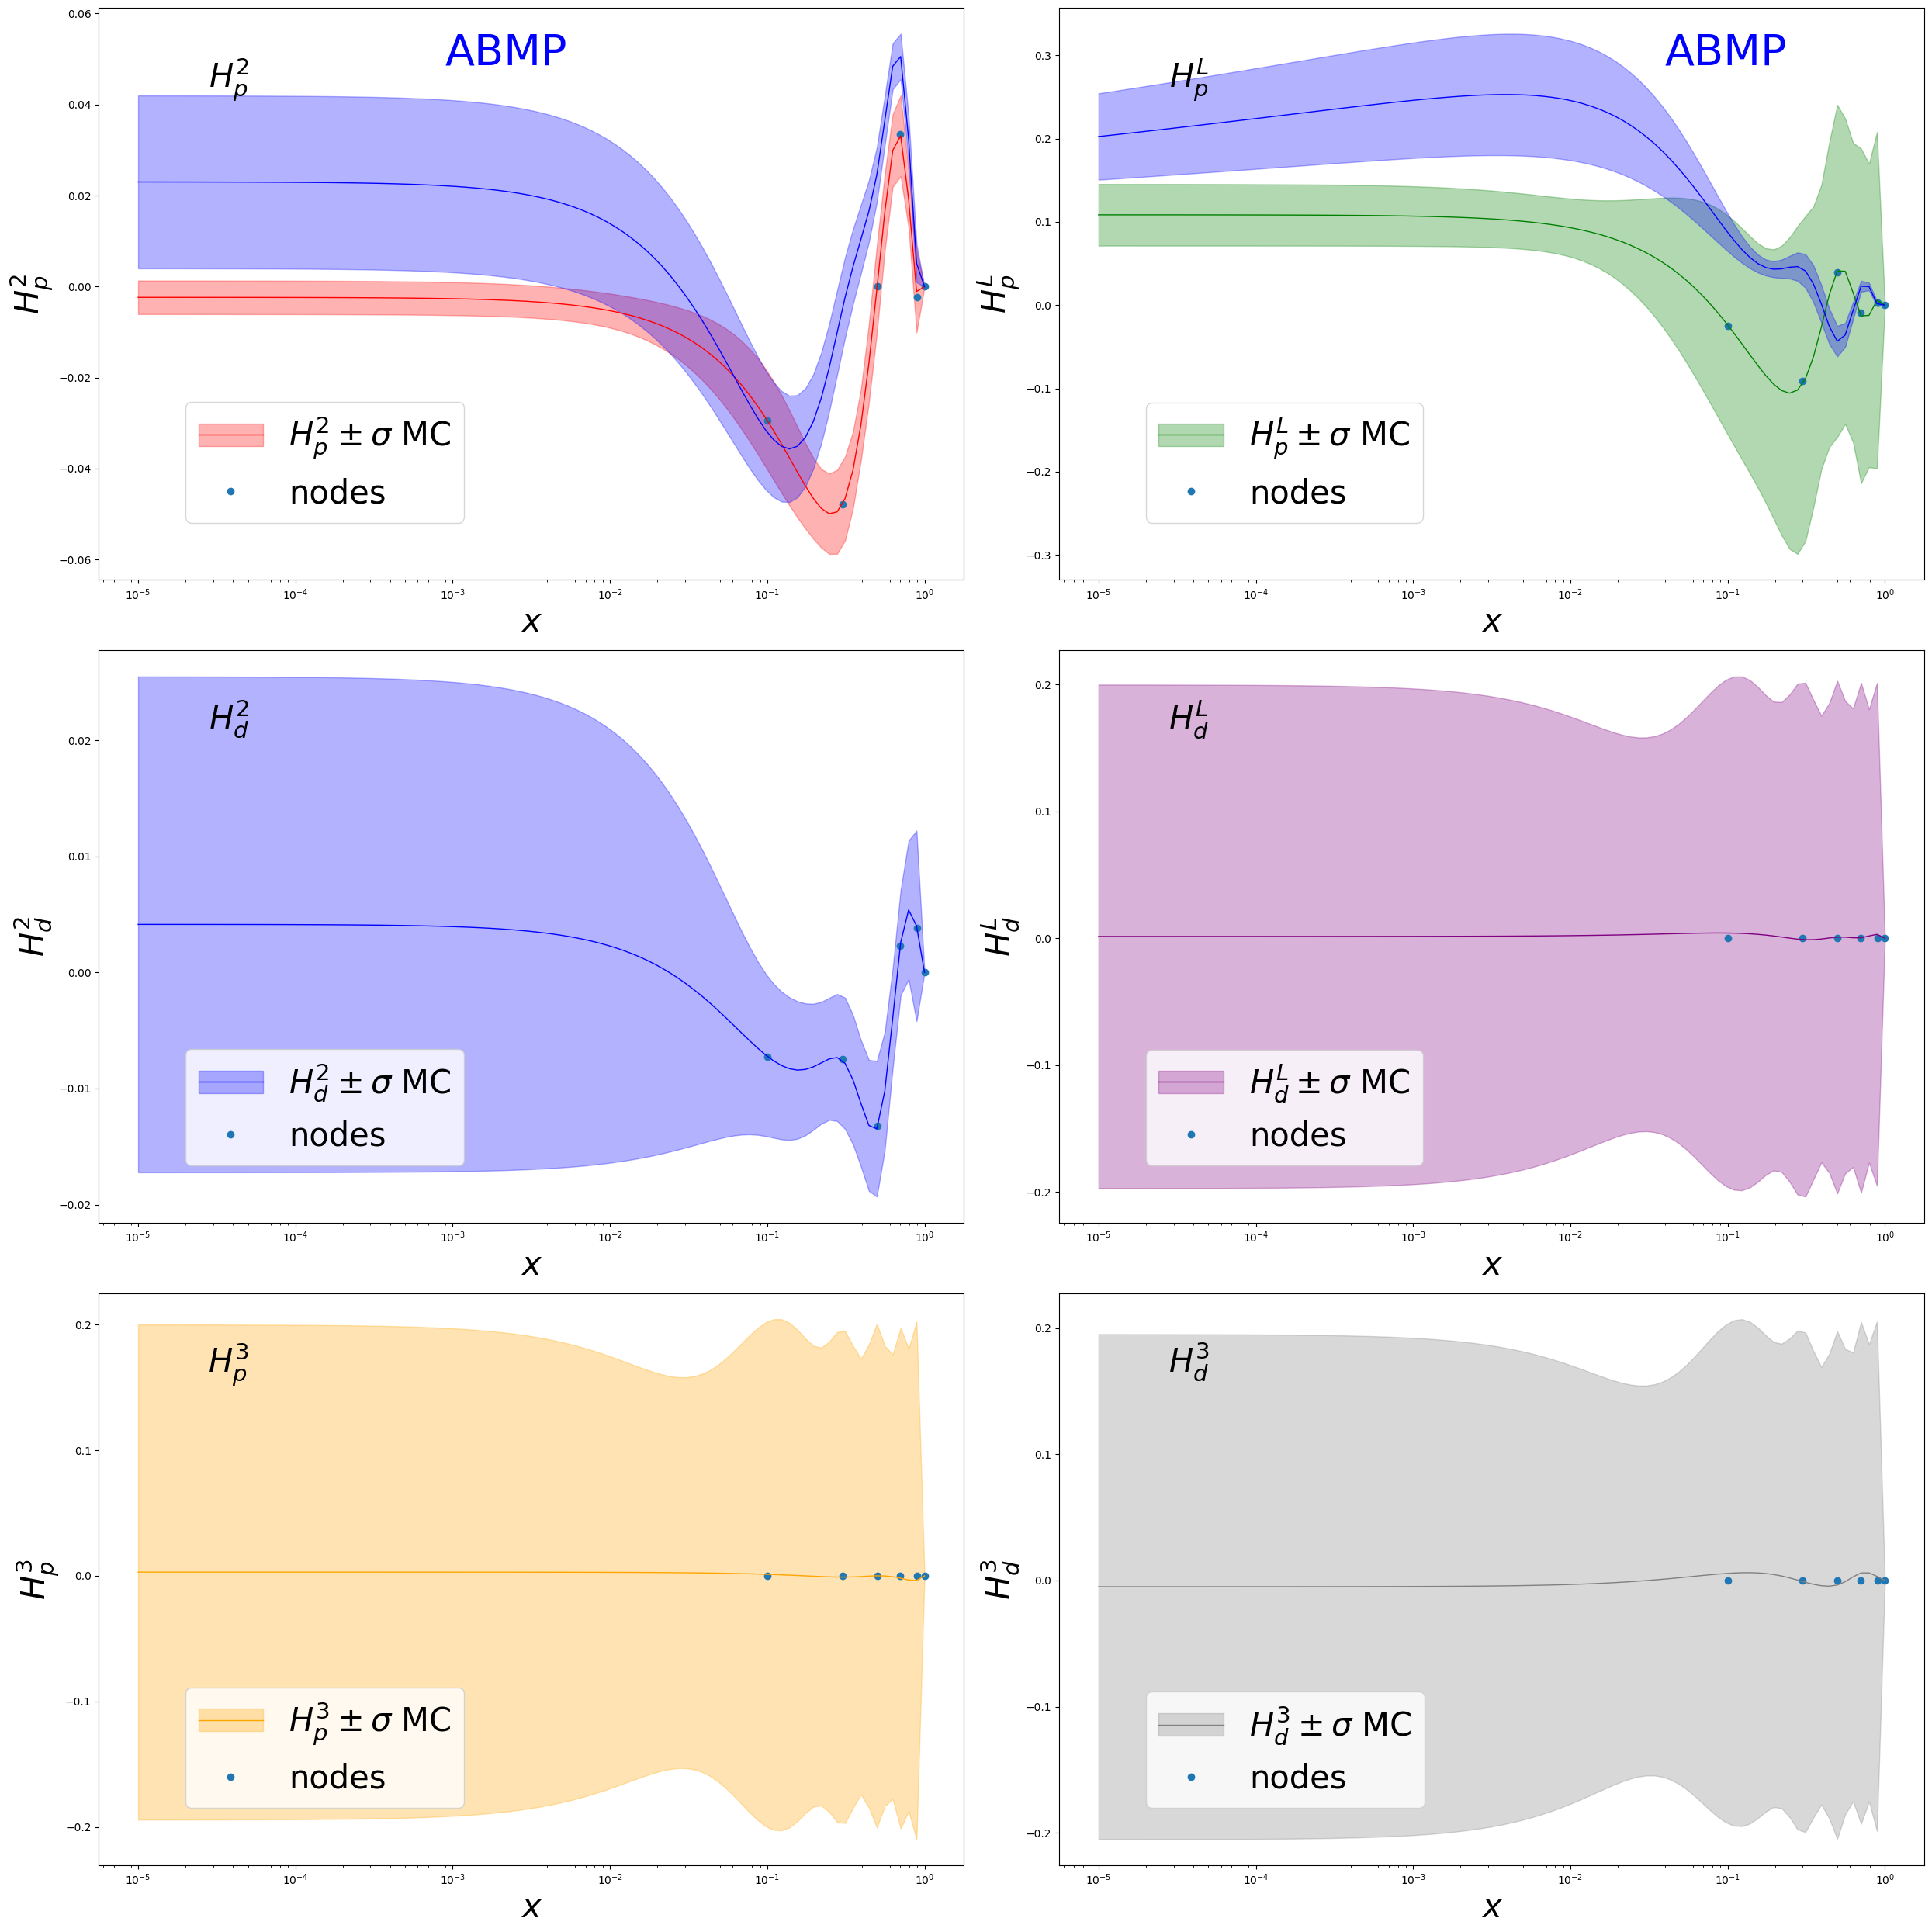

In [170]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
color = 'lightblue'
legends = []
legend_names = []
colors = ["red", "green", "blue", "purple", "orange", "grey"]
abmp = True

xv = np.logspace(-5, -0.0001, 100)

for idx_ax, (ax, key, color) in enumerate(zip(axs.flatten(), ["H2p", "HLp", "H2d", "HLd", "H3p", "H3d"], colors)):
  htf = HT(xv, key)
  central = htf.mean(axis=1)
  std = htf.std(axis=1)

  central_nodes = np.concatenate([HT.central_nodes.xs(level="HT", key=key).to_numpy(), [0]])
  nodes = ax.plot(x_nodes[key], central_nodes, 'o', label='data')
  pl = ax.plot(xv, central, ls = "-", lw = 1, color = color)
  pl_lg = ax.fill(np.NaN, np.NaN, alpha = 0.3, color = pl[0].get_color()) # Necessary for fancy legend
  pl_fb  = ax.fill_between(xv, central - std, central + std , color = pl[0].get_color(),  alpha = 0.3)
  ax.set_xscale("log")
  ax.set_xlabel(f'$x$', fontsize = 30)
  ax.set_ylabel(rf"$H^{key[1]}_{key[2]}$", fontsize = 30)
  ax.set_title(rf"$H^{key[1]}_{key[2]}$", x = 0.15, y=0.85, fontsize=30)
  
  label = rf"$H^{key[1]}_{key[2]} \pm \sigma$ MC"
  ax.legend([(pl[0], pl_lg[0]), nodes[0]], [label, "nodes"], loc=[0.1, 0.1], fontsize=30)
  ax.set_xscale('log')

fig.tight_layout()
fig.savefig(save_dir + "/ht_plots.png")

if abmp:
  axs[0][0].plot(xv, H_2_abmp(xv), ls = "-", lw = 1, color = 'blue', label="ABMP")
  axs[0][0].fill(np.NaN, np.NaN, color = 'blue', alpha = 0.3) # Necessary for fancy legend
  axs[0][0].fill_between(xv, H2_plus_abmp(xv), H2_minus_abmp(xv), color = 'blue', alpha = 0.3)
  axs[0][0].text(0.4, 0.9, "ABMP",transform=axs[0][0].transAxes, fontsize=40, color="blue")

  HL_abmp = H_L(xv, H_2_abmp(xv), H_T_abmp(xv))
  axs[0][1].plot(xv, HL_abmp, ls = "-", lw = 1, color = 'blue')
  axs[0][1].fill(np.NaN, np.NaN, color = 'blue', alpha = 0.3) # Necessary for fancy legend
  axs[0][1].fill_between(xv, 
                         np.add(H2_plus_abmp(xv), -np.power(xv, 0.05) * Ht_plus_abmp(xv)), 
                         np.add(H2_minus_abmp(xv), -np.power(xv, 0.05) * Ht_minus_abmp(xv)),
                         color = 'blue', alpha = 0.3)
  axs[0][1].text(0.7, 0.9, "ABMP",transform=axs[0][1].transAxes, fontsize=40, color="blue")

fig.tight_layout()
fig.savefig(save_dir + "/comparison_abmp.png")




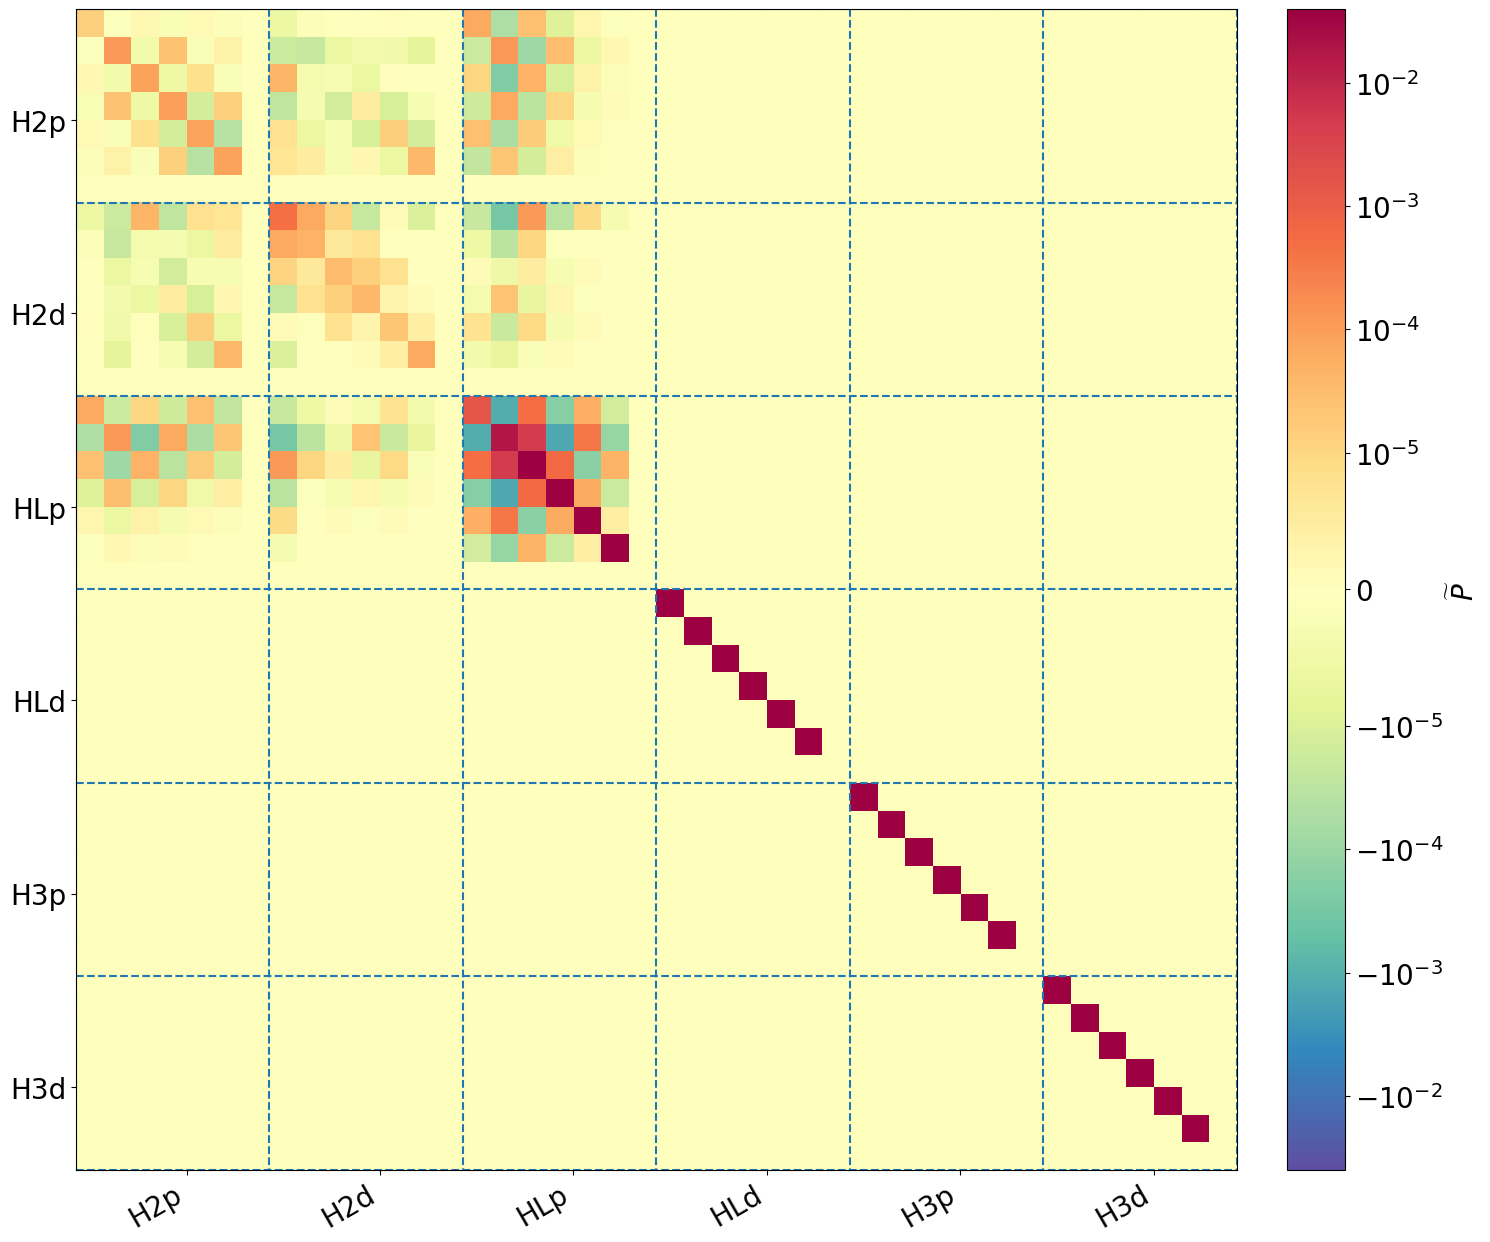

In [111]:
fig_matmap =plot_covmat_heatmap(P_tilde, "")

fig_matmap.tight_layout()
fig_matmap.savefig(save_dir + '/heatmap.png')

# TABLE

In [171]:
class Prediction:
  def __init__(self, central, sigma):
    self.central = central
    self.sigma = sigma
    self.central_plus_sigma = central + sigma
    self.central_minus_sigma = central - sigma

  def __str__(self) -> str:
    return f"{self.central:.5f} ± {self.sigma:.3f}"

def map_target(i, list_length):
  if i < list_length/2:
    return "proton"
  else:
    return "deutron"
  
def map_type(i, list_length):
  if i%list_length/4 < list_length/4:
    return "H2"
  else:
    return "HL"


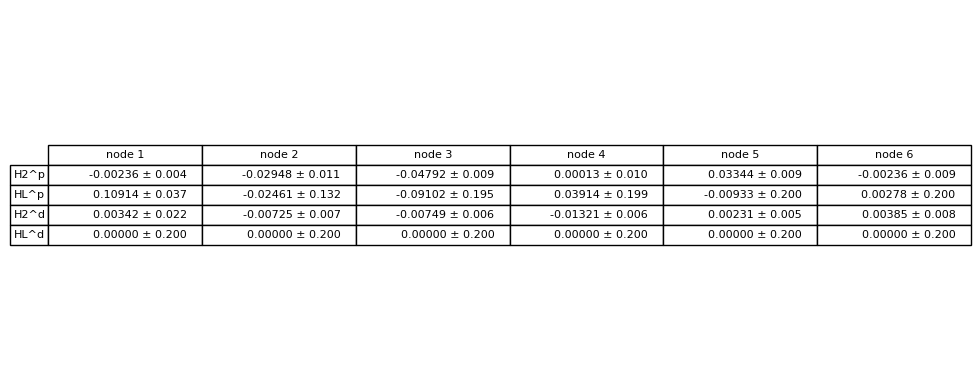

In [ ]:
preds_dict = defaultdict(list)
preds_dict['proton'] = {"H2": [Prediction(central, sigma) 
                               for central, sigma in zip(posteriors.xs("H2p", level="HT").to_numpy().reshape((-1)), 
                                                         np.sqrt(P_tilde.xs("H2p", level="HT").T.xs("H2p", level="HT").to_numpy().diagonal())
                                                         )], 
                        "HL": [Prediction(central, sigma) for central, sigma in zip(posteriors.xs("HLp", level="HT").to_numpy().reshape((-1)), 
                                                      np.sqrt(P_tilde.xs("HLp", level="HT").T.xs("HLp", level="HT").to_numpy().diagonal()))]}
preds_dict['deuteron'] = {"H2": [Prediction(central, sigma) for central, sigma in zip(posteriors.xs("H2d", level="HT").to_numpy().reshape((-1)), 
                                                      np.sqrt(P_tilde.xs("H2d", level="HT").T.xs("H2d", level="HT").to_numpy().diagonal()))], 
                          "HL": [Prediction(central, sigma) for central, sigma in zip(posteriors.xs("HLd", level="HT").to_numpy().reshape((-1)), 
                                                      np.sqrt(P_tilde.xs("HLd", level="HT").T.xs("HLd", level="HT").to_numpy().diagonal()))]}

df = pd.DataFrame(np.zeros((4, len(x_nodes))), columns=[f"node {i+1}" for i in range(len(x_nodes))])
df.index = ["H2^p","HL^p","H2^d","HL^d"]
for i in range(len(x_nodes)):
  array = [
    preds_dict['proton']['H2'][i].__str__(),
    preds_dict['proton']['HL'][i].__str__(),
    preds_dict['deuteron']['H2'][i].__str__(),
    preds_dict['deuteron']['HL'][i].__str__()
  ]
  df[f'node {i+1}'] = array


fig_table, ax_posterior = plt.subplots(figsize=(10, 4))  # Set the figure size
ax_posterior.axis('tight')
ax_posterior.axis('off')  # Turn off the axis

# Create a table plot from the DataFrame
table = ax_posterior.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

fig_table.tight_layout()
fig_table.savefig(save_dir + "/table.png")